In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os

# --- Configurable ---
BROKER_FEE = 0.00
SALES_TAX = 0.00

# --- Find CSVs ---
data_folder = r"C:\Users\Jouke\Documents\evedata-logger\output"
market_history_files = glob.glob(os.path.join(data_folder, "market_history_*.csv"))
if not market_history_files:
    raise RuntimeError(f"No CSVs found in {data_folder}")

print(f"Found {len(market_history_files)} CSV files for analysis.")

# --- Read and concatenate ---
df_list = [pd.read_csv(f, parse_dates=['date']) for f in market_history_files]
df = pd.concat(df_list, ignore_index=True)

# --- Strategy simulators ---
def simulate_crossover(item_df, series, window):
    sig = item_df['average'] > item_df[series]
    buy_signals = sig & (~sig.shift(1, fill_value=False))
    sell_signals = ~sig & (sig.shift(1, fill_value=False))
    signals = item_df.copy()
    signals['signal'] = 0
    signals.loc[buy_signals, 'signal'] = 1
    signals.loc[sell_signals, 'signal'] = -1
    trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
    if not trades.empty and trades.iloc[0]['signal'] == -1:
        trades = trades.iloc[1:].reset_index(drop=True)
    if len(trades) % 2 == 1:
        trades = trades.iloc[:-1]
    profits, buy_prices = [], []
    for i in range(0, len(trades), 2):
        buy_price = trades.iloc[i]['average']
        sell_price = trades.iloc[i+1]['average']
        buy_fee = buy_price * BROKER_FEE
        sell_fee = sell_price * BROKER_FEE
        sales_tax = sell_price * SALES_TAX
        net = (sell_price - buy_price) - (buy_fee + sell_fee + sales_tax)
        profits.append(net)
        buy_prices.append(buy_price)
    return profits, buy_prices

def simulate_crossover_vol(item_df, series, window, vol_window, vol_thresh):
    sig = item_df['average'] > item_df[series]
    buy_signals = sig & (~sig.shift(1, fill_value=False))
    sell_signals = ~sig & (sig.shift(1, fill_value=False))
    signals = item_df.copy()
    signals['signal'] = 0
    signals.loc[buy_signals, 'signal'] = 1
    signals.loc[sell_signals, 'signal'] = -1
    trades = signals[signals['signal'] != 0][['date', 'average', 'signal', 'volatility']].reset_index(drop=True)
    if not trades.empty and trades.iloc[0]['signal'] == -1:
        trades = trades.iloc[1:].reset_index(drop=True)
    if len(trades) % 2 == 1:
        trades = trades.iloc[:-1]
    profits, buy_prices = [], []
    tdf = item_df.set_index('date')
    for i in range(0, len(trades), 2):
        buy_row = trades.iloc[i]
        buy_date = buy_row['date']
        buy_price = buy_row['average']
        sell_row = trades.iloc[i+1]
        sell_date = sell_row['date']
        held_period = tdf.loc[(tdf.index > buy_date) & (tdf.index <= sell_date)]
        spike = held_period[held_period['volatility'] >= vol_thresh]
        if not spike.empty:
            exit_date = spike.index[0]
            exit_price = tdf.loc[exit_date]['average']
            sell_price = exit_price
        else:
            sell_price = sell_row['average']
        buy_fee = buy_price * BROKER_FEE
        sell_fee = sell_price * BROKER_FEE
        sales_tax = sell_price * SALES_TAX
        net = (sell_price - buy_price) - (buy_fee + sell_fee + sales_tax)
        profits.append(net)
        buy_prices.append(buy_price)
    return profits, buy_prices

def simulate_rsi(item_df, rsi_col='RSI', buy_thresh=30, sell_thresh=70):
    signals = item_df.copy()
    signals['signal'] = 0
    signals.loc[signals[rsi_col] < buy_thresh, 'signal'] = 1
    signals.loc[signals[rsi_col] > sell_thresh, 'signal'] = -1
    trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
    if not trades.empty and trades.iloc[0]['signal'] == -1:
        trades = trades.iloc[1:].reset_index(drop=True)
    if len(trades) % 2 == 1:
        trades = trades.iloc[:-1]
    profits, buy_prices = [], []
    for i in range(0, len(trades), 2):
        buy_price = trades.iloc[i]['average']
        sell_price = trades.iloc[i+1]['average']
        net = (sell_price - buy_price)
        profits.append(net)
        buy_prices.append(buy_price)
    return profits, buy_prices

def simulate_bb(item_df, bb_lower='BB_lower', bb_upper='BB_upper'):
    signals = item_df.copy()
    signals['signal'] = 0
    signals.loc[signals['average'] < signals[bb_lower], 'signal'] = 1
    signals.loc[signals['average'] > signals[bb_upper], 'signal'] = -1
    trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
    if not trades.empty and trades.iloc[0]['signal'] == -1:
        trades = trades.iloc[1:].reset_index(drop=True)
    if len(trades) % 2 == 1:
        trades = trades.iloc[:-1]
    profits, buy_prices = [], []
    for i in range(0, len(trades), 2):
        buy_price = trades.iloc[i]['average']
        sell_price = trades.iloc[i+1]['average']
        net = (sell_price - buy_price)
        profits.append(net)
        buy_prices.append(buy_price)
    return profits, buy_prices

def simulate_macd(item_df, macd_col='MACD', signal_col='MACD_signal'):
    sig = item_df[macd_col] > item_df[signal_col]
    buy_signals = sig & (~sig.shift(1, fill_value=False))
    sell_signals = ~sig & (sig.shift(1, fill_value=False))
    signals = item_df.copy()
    signals['signal'] = 0
    signals.loc[buy_signals, 'signal'] = 1
    signals.loc[sell_signals, 'signal'] = -1
    trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
    if not trades.empty and trades.iloc[0]['signal'] == -1:
        trades = trades.iloc[1:].reset_index(drop=True)
    if len(trades) % 2 == 1:
        trades = trades.iloc[:-1]
    profits, buy_prices = [], []
    for i in range(0, len(trades), 2):
        buy_price = trades.iloc[i]['average']
        sell_price = trades.iloc[i+1]['average']
        net = (sell_price - buy_price)
        profits.append(net)
        buy_prices.append(buy_price)
    return profits, buy_prices

# --- Main analysis function ---
def analyze_all_strategies(df, min_ma=2, max_ma=60, min_vol=3, max_vol=60):
    items = list(df['type_name'].unique())
    n_ma = max_ma - min_ma + 1
    n_vol = ((max_vol - min_vol) // 10) + 1
    n_strat = 10  # Adjusted for all strategies below
    total = len(items) * n_ma * n_vol * n_strat

    pbar = tqdm(total=total, desc="Analyzing strategies", ncols=90)
    results = []
    for item in items:
        item_df = df[df['type_name'] == item].sort_values('date').copy()
        if len(item_df) < max(max_ma, max_vol):
            pbar.update(n_ma * n_vol * n_strat)
            continue
        for ma_window in range(min_ma, max_ma + 1):
            # Indicators
            item_df['MA'] = item_df['average'].rolling(window=ma_window, min_periods=1).mean()
            item_df['EMA'] = item_df['average'].ewm(span=ma_window, adjust=False).mean()
            # WMA
            weights = np.arange(1, ma_window+1)
            item_df['WMA'] = item_df['average'].rolling(ma_window, min_periods=1).apply(
                lambda x: np.dot(x, weights[-len(x):])/weights[-len(x):].sum(), raw=True)
            # RSI
            delta = item_df['average'].diff()
            up = delta.clip(lower=0)
            down = -delta.clip(upper=0)
            roll_up = up.rolling(ma_window, min_periods=1).mean()
            roll_down = down.rolling(ma_window, min_periods=1).mean()
            rs = roll_up / roll_down.replace(0, np.nan)
            item_df['RSI'] = 100 - (100 / (1 + rs))
            # MACD
            ema_fast = item_df['average'].ewm(span=12, adjust=False).mean()
            ema_slow = item_df['average'].ewm(span=26, adjust=False).mean()
            item_df['MACD'] = ema_fast - ema_slow
            item_df['MACD_signal'] = item_df['MACD'].ewm(span=9, adjust=False).mean()
            # Bollinger Bands
            ma = item_df['MA']
            std = item_df['average'].rolling(ma_window, min_periods=1).std()
            item_df['BB_upper'] = ma + 2 * std
            item_df['BB_lower'] = ma - 2 * std
            for vol_window in range(min_vol, max_vol + 1, 10):
                item_df['volatility'] = item_df['average'].rolling(window=vol_window, min_periods=1).std()
                vol_thresh = item_df['volatility'].mean() + item_df['volatility'].std()
                
                # MA
                ma_profits, ma_buys = simulate_crossover(item_df, 'MA', ma_window)
                ma_profit = sum(ma_profits)
                ma_cap = sum(ma_buys)
                ma_roi = (ma_profit / ma_cap * 100) if ma_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'MA', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': ma_profit, 'roi': ma_roi, 'trades': len(ma_profits)})
                pbar.update(1)
                
                # EMA
                ema_profits, ema_buys = simulate_crossover(item_df, 'EMA', ma_window)
                ema_profit = sum(ema_profits)
                ema_cap = sum(ema_buys)
                ema_roi = (ema_profit / ema_cap * 100) if ema_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'EMA', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': ema_profit, 'roi': ema_roi, 'trades': len(ema_profits)})
                pbar.update(1)

                # WMA
                wma_profits, wma_buys = simulate_crossover(item_df, 'WMA', ma_window)
                wma_profit = sum(wma_profits)
                wma_cap = sum(wma_buys)
                wma_roi = (wma_profit / wma_cap * 100) if wma_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'WMA', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': wma_profit, 'roi': wma_roi, 'trades': len(wma_profits)})
                pbar.update(1)

                # RSI
                rsi_profits, rsi_buys = simulate_rsi(item_df, 'RSI', 30, 70)
                rsi_profit = sum(rsi_profits)
                rsi_cap = sum(rsi_buys)
                rsi_roi = (rsi_profit / rsi_cap * 100) if rsi_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'RSI', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': rsi_profit, 'roi': rsi_roi, 'trades': len(rsi_profits)})
                pbar.update(1)

                # MACD
                macd_profits, macd_buys = simulate_macd(item_df, 'MACD', 'MACD_signal')
                macd_profit = sum(macd_profits)
                macd_cap = sum(macd_buys)
                macd_roi = (macd_profit / macd_cap * 100) if macd_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'MACD', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': macd_profit, 'roi': macd_roi, 'trades': len(macd_profits)})
                pbar.update(1)

                # Bollinger Bands
                bb_profits, bb_buys = simulate_bb(item_df, 'BB_lower', 'BB_upper')
                bb_profit = sum(bb_profits)
                bb_cap = sum(bb_buys)
                bb_roi = (bb_profit / bb_cap * 100) if bb_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'BB', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': bb_profit, 'roi': bb_roi, 'trades': len(bb_profits)})
                pbar.update(1)

                # MA + Vol
                ma_vol_profits, ma_vol_buys = simulate_crossover_vol(item_df, 'MA', ma_window, vol_window, vol_thresh)
                ma_vol_profit = sum(ma_vol_profits)
                ma_vol_cap = sum(ma_vol_buys)
                ma_vol_roi = (ma_vol_profit / ma_vol_cap * 100) if ma_vol_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'MA+Vol', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': ma_vol_profit, 'roi': ma_vol_roi, 'trades': len(ma_vol_profits)})
                pbar.update(1)

                # EMA + Vol
                ema_vol_profits, ema_vol_buys = simulate_crossover_vol(item_df, 'EMA', ma_window, vol_window, vol_thresh)
                ema_vol_profit = sum(ema_vol_profits)
                ema_vol_cap = sum(ema_vol_buys)
                ema_vol_roi = (ema_vol_profit / ema_vol_cap * 100) if ema_vol_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'EMA+Vol', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': ema_vol_profit, 'roi': ema_vol_roi, 'trades': len(ema_vol_profits)})
                pbar.update(1)

                # WMA + Vol
                wma_vol_profits, wma_vol_buys = simulate_crossover_vol(item_df, 'WMA', ma_window, vol_window, vol_thresh)
                wma_vol_profit = sum(wma_vol_profits)
                wma_vol_cap = sum(wma_vol_buys)
                wma_vol_roi = (wma_vol_profit / wma_vol_cap * 100) if wma_vol_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'WMA+Vol', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': wma_vol_profit, 'roi': wma_vol_roi, 'trades': len(wma_vol_profits)})
                pbar.update(1)

                # BB + Vol
                bb_vol_profits, bb_vol_buys = simulate_crossover_vol(item_df, 'BB_lower', ma_window, vol_window, vol_thresh)  # Buy when avg < lower band
                bb_vol_profit = sum(bb_vol_profits)
                bb_vol_cap = sum(bb_vol_buys)
                bb_vol_roi = (bb_vol_profit / bb_vol_cap * 100) if bb_vol_cap > 0 else float('nan')
                results.append({'item': item, 'strategy': 'BB+Vol', 'ma_window': ma_window, 'vol_window': vol_window, 'profit': bb_vol_profit, 'roi': bb_vol_roi, 'trades': len(bb_vol_profits)})
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(results)

# --- ANALYZE ALL CSVs AND STRATEGIES ---
print("Analyzing all strategies across all items (this may take a while)...")
results_df = analyze_all_strategies(df)

# Sort and display the top strategies by ROI
top_n = 20
top_roi = results_df.sort_values('roi', ascending=False).head(top_n)
print(f"\nTop {top_n} strategies by ROI across all items and windows:")
print(top_roi[['item', 'strategy', 'ma_window', 'vol_window', 'profit', 'roi', 'trades']].to_string(index=False))

# Optional: Save results for further exploration
results_df.to_csv('MA_EMA_WMA_RSI_MACD_BB_ROI_results.csv', index=False)


Found 3 CSV files for analysis.
Analyzing all strategies across all items (this may take a while)...


Analyzing strategies: 100%|███████████████████████| 169920/169920 [36:12<00:00, 78.21it/s]



Top 20 strategies by ROI across all items and windows:
     item strategy  ma_window  vol_window  profit         roi  trades
Eleutrium       BB         49           3   18.29 1075.882353       1
Eleutrium       BB         50          53   18.29 1075.882353       1
Eleutrium       BB         50          43   18.29 1075.882353       1
Eleutrium       BB         51          13   18.29 1075.882353       1
Eleutrium       BB         51           3   18.29 1075.882353       1
Eleutrium       BB         51          43   18.29 1075.882353       1
Eleutrium       BB         51          33   18.29 1075.882353       1
Eleutrium       BB         50           3   18.29 1075.882353       1
Eleutrium       BB         49          53   18.29 1075.882353       1
Eleutrium       BB         47          13   18.29 1075.882353       1
Eleutrium       BB         48          53   18.29 1075.882353       1
Eleutrium       BB         50          13   18.29 1075.882353       1
Eleutrium       BB         50     

Average ROI by strategy across ALL items and parameter sets:

strategy
BB         3.094170
RSI        1.828288
BB+Vol    -1.434427
WMA+Vol   -3.895435
MA+Vol    -3.902294
EMA+Vol   -4.034884
WMA       -5.133203
MA        -5.275721
EMA       -5.339238
MACD      -6.425882
Name: roi, dtype: float64


Best parameter set for each (item, strategy):

           item strategy  ma_window  vol_window        roi        profit  \
67529   Abaddon   BB+Vol          6          23  16.967456  5.735000e+07   
68343   Abaddon      RSI         20           3   6.846621  1.040428e+08   
69845   Abaddon       BB         45           3   3.359565  1.509976e+08   
70207   Abaddon  EMA+Vol         51           3   0.922700  8.241365e+07   
70746   Abaddon   MA+Vol         60           3   0.541308  4.495584e+07   
...         ...      ...        ...         ...        ...           ...   
151608  Zydrine  WMA+Vol         50          43   4.047504  1.762000e+03   
151921  Zydrine      EMA         56           

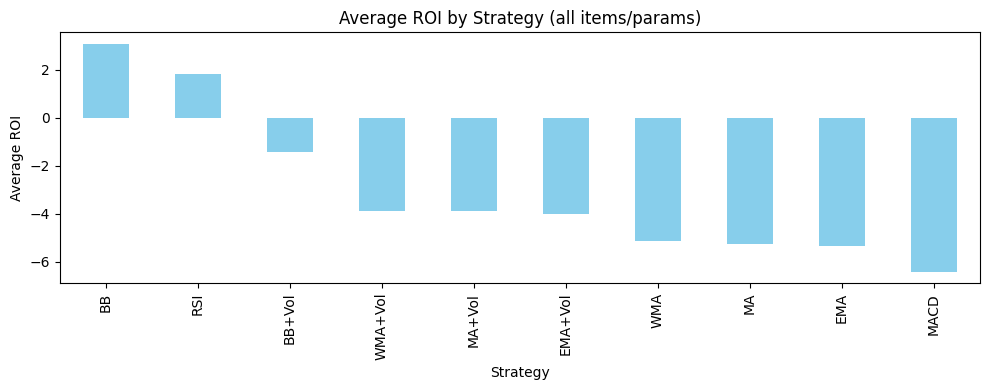

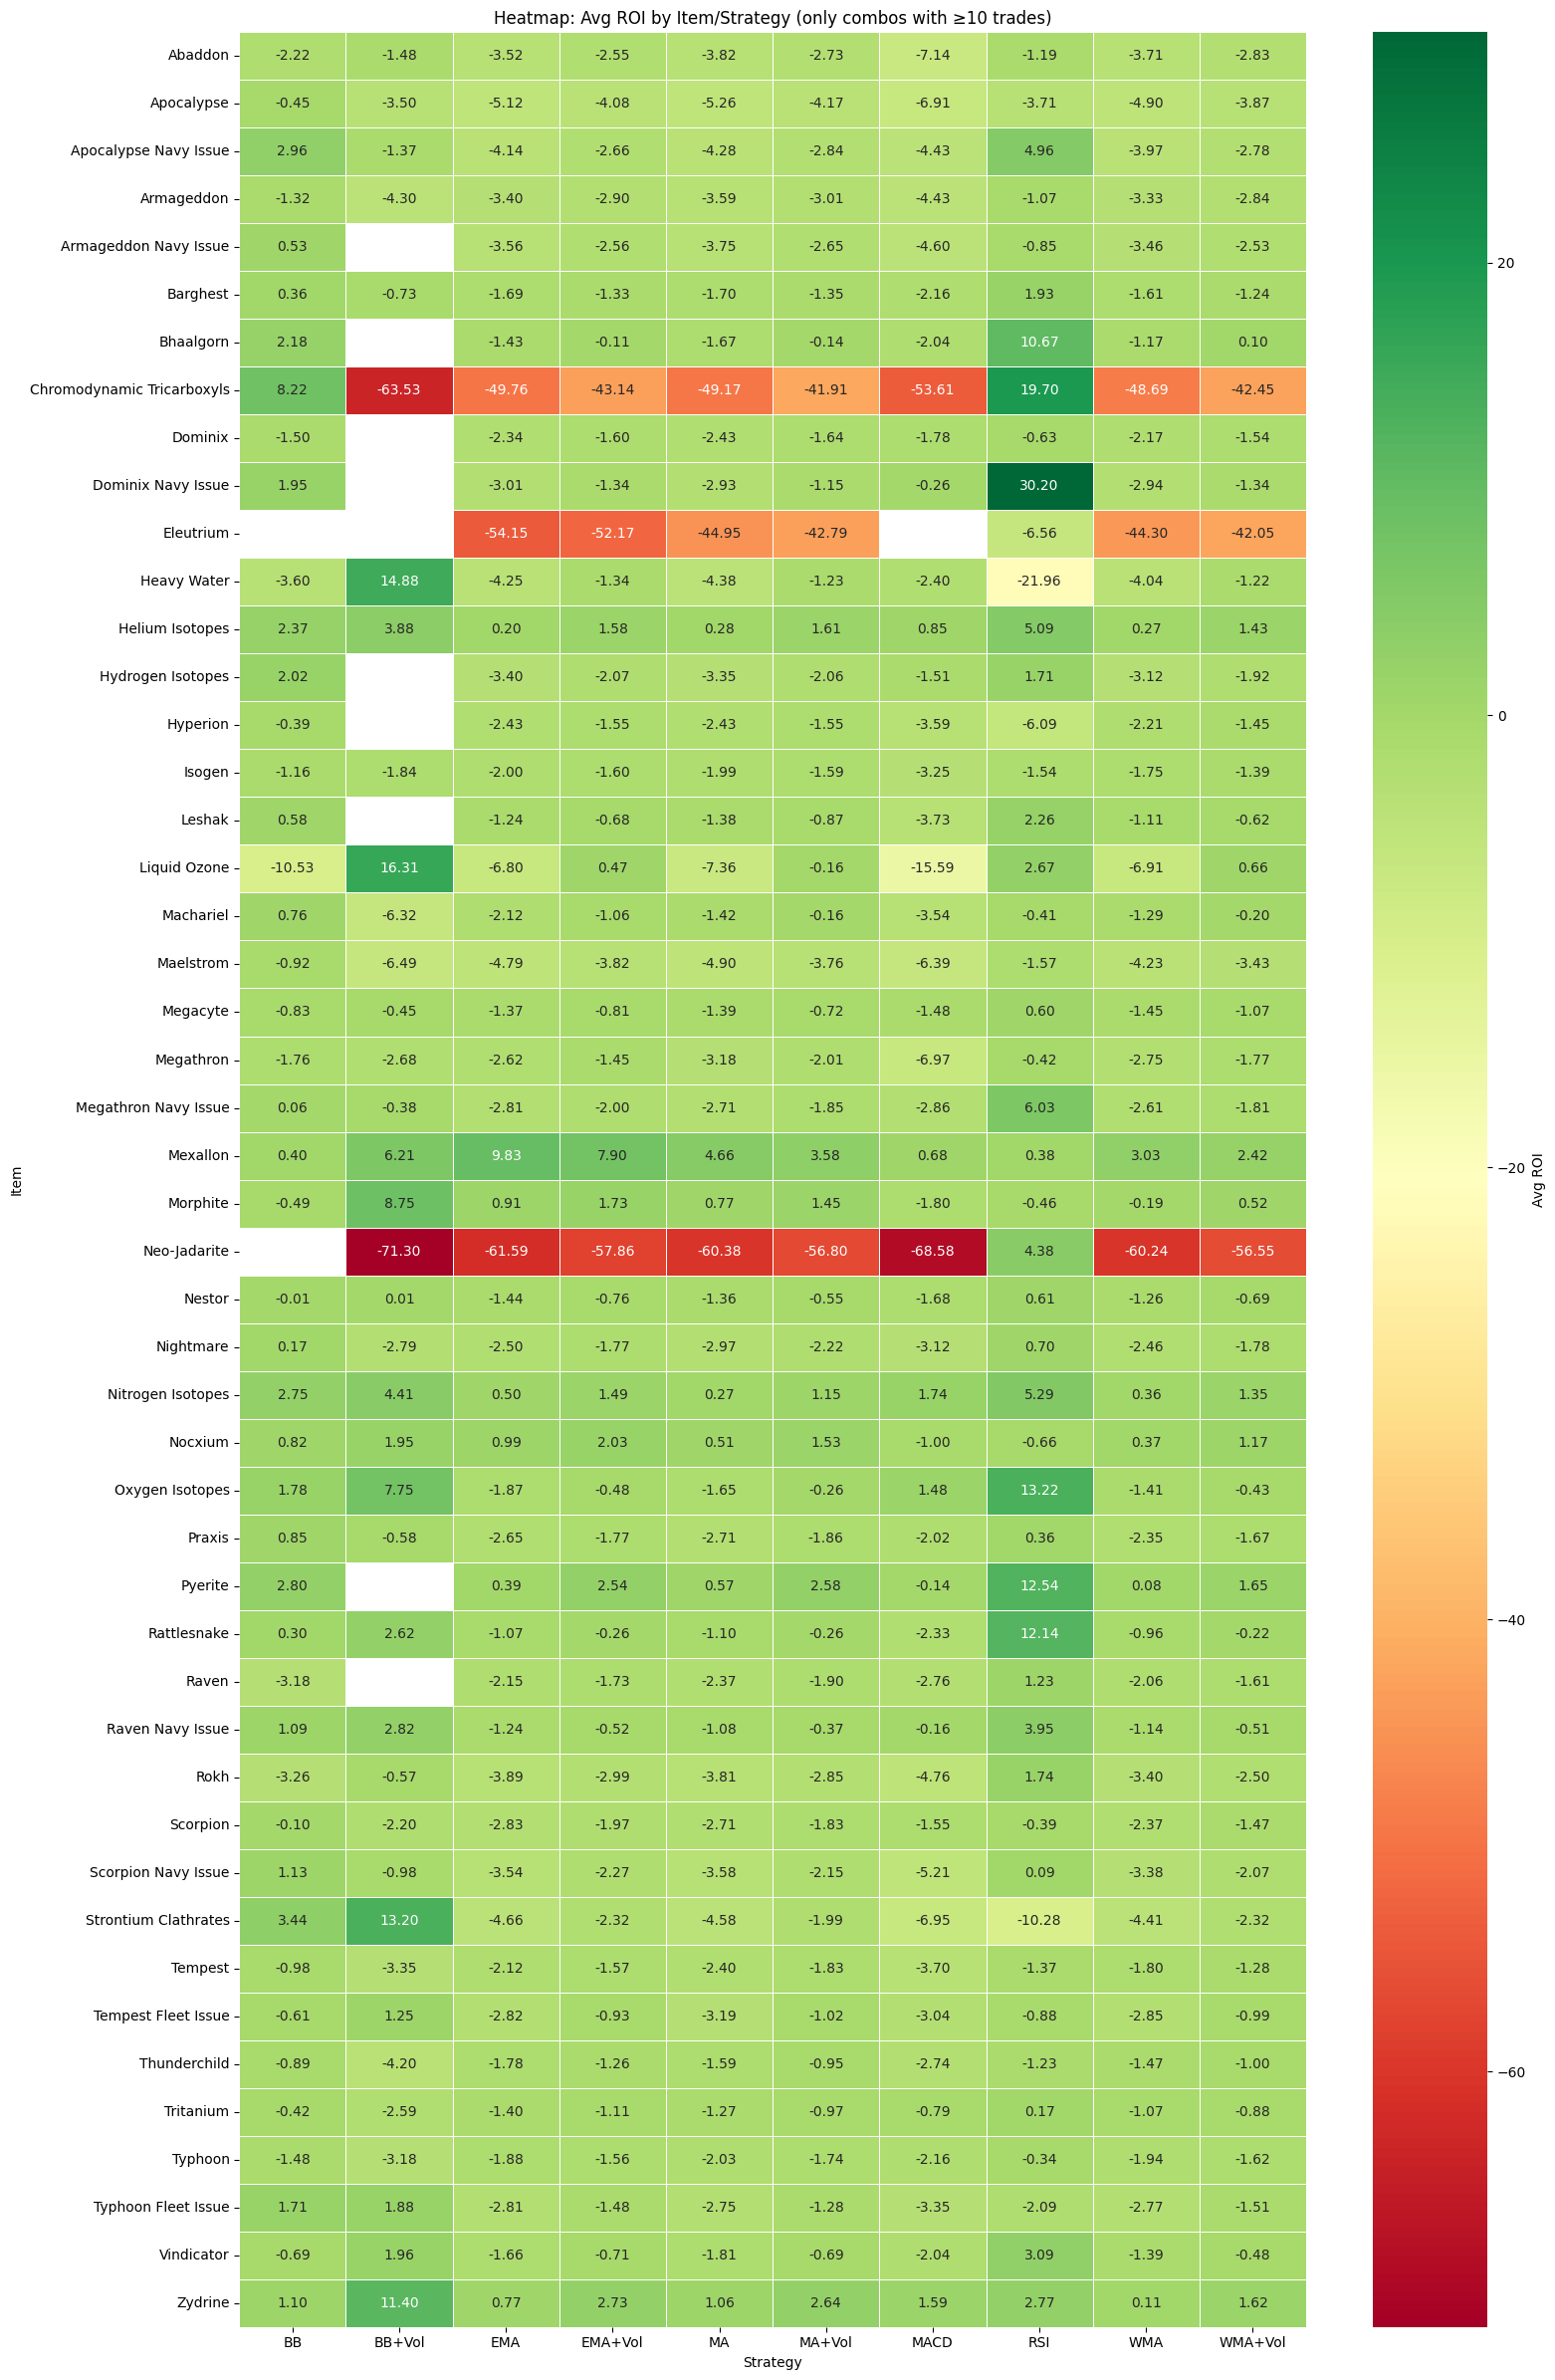


For robust edges, always check trade counts >= 10, ideally much higher.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
CSV_PATH = r"C:\Users\Jouke\Documents\evedata-logger\output\MA_EMA_WMA_RSI_MACD_BB_ROI_results.csv"
TOP_N = 20           # Top N runs to display
MIN_TRADES = 10      # Minimum trades for robust run
HEATMAP_MIN_TRADES = 10  # For the pivot/heatmap: only include strategy/item if any run has >= this many trades

# --- LOAD DATA ---
results_df = pd.read_csv(CSV_PATH)

# --- 1. Average ROI by strategy (all items/params) ---
roi_by_strategy = results_df.groupby('strategy')['roi'].mean().sort_values(ascending=False)
print("Average ROI by strategy across ALL items and parameter sets:\n")
print(roi_by_strategy)
print('\n' + '='*60 + '\n')

# --- 2. Best parameter set for each (item, strategy) ---
best_by_item_strategy = results_df.loc[results_df.groupby(['item', 'strategy'])['roi'].idxmax()]
print("Best parameter set for each (item, strategy):\n")
print(best_by_item_strategy[['item', 'strategy', 'ma_window', 'vol_window', 'roi', 'profit', 'trades']].sort_values(['item','roi'], ascending=[True, False]))
print('\n' + '='*60 + '\n')

# --- 3. Top N runs by ROI (with at least MIN_TRADES trades) ---
top_roi = results_df[results_df['trades'] >= MIN_TRADES].sort_values('roi', ascending=False).head(TOP_N)
print(f"Top {TOP_N} runs by ROI (with at least {MIN_TRADES} trades):\n")
print(top_roi[['item', 'strategy', 'ma_window', 'vol_window', 'roi', 'profit', 'trades']])
print('\n' + '='*60 + '\n')

# --- 4. Average ROI by item and strategy (pivot table, all runs) ---
pivot_all = (
    results_df.groupby(['item', 'strategy'])['roi']
    .mean()
    .unstack()
    .round(3)
    .fillna('')
)
print("Average ROI by item and strategy (pivot table, all runs):")
print(pivot_all)
print('\n' + '='*60 + '\n')

# --- 5. Pivot Table: only strategy/item combos with at least HEATMAP_MIN_TRADES in ANY run ---
eligible = results_df.groupby(['item', 'strategy'])['trades'].max().reset_index()
eligible = eligible[eligible['trades'] >= HEATMAP_MIN_TRADES]
mask = pd.merge(results_df, eligible, on=['item','strategy'], how='inner')
pivot_trades = mask.groupby(['item','strategy'])['roi'].mean().unstack().round(3)
print(f"Pivot Table (Only showing strategy/item combos with ≥{HEATMAP_MIN_TRADES} trades in any run):")
print(pivot_trades)
print('\n' + '='*60 + '\n')

# --- 6. Visualize average ROI by strategy ---
plt.figure(figsize=(10, 4))
roi_by_strategy.plot(kind='bar', color='skyblue')
plt.title('Average ROI by Strategy (all items/params)')
plt.ylabel('Average ROI')
plt.xlabel('Strategy')
plt.tight_layout()
plt.show()

# --- 7. Heatmap: Average ROI by item and strategy (only robust runs) ---
plt.figure(figsize=(16, max(8, len(pivot_trades)//2)))
sns.heatmap(pivot_trades, annot=True, fmt=".2f", cmap="RdYlGn", linewidths=0.5, cbar_kws={'label': 'Avg ROI'})
plt.title(f'Heatmap: Avg ROI by Item/Strategy (only combos with ≥{HEATMAP_MIN_TRADES} trades)')
plt.ylabel('Item')
plt.xlabel('Strategy')
plt.tight_layout()
plt.show()

# --- 8. Warning: High ROI, Low Trade Count? ---
print("\nWarning: Many high-ROI results may have low trade counts (possible overfitting/luck).")
print(f"For robust edges, always check trade counts >= {MIN_TRADES}, ideally much higher.\n")


In [6]:
import pandas as pd

# --- CONFIG ---
CSV_PATH = r"C:\Users\Jouke\Documents\evedata-logger\output\MA_EMA_WMA_RSI_MACD_BB_ROI_results.csv"
MIN_TRADES_ROBUST = 30    # Minimum trades to consider robust

# --- LOAD DATA ---
results_df = pd.read_csv(CSV_PATH)

# --- STEP 1: Filter for robust positive-ROI strategies ---
robust = results_df[(results_df['roi'] > 0) & (results_df['trades'] >= MIN_TRADES_ROBUST)]

print(f"\nRobust (ROI > 0, trades ≥ {MIN_TRADES_ROBUST}) strategies found: {len(robust)}")
print(
    robust[['item', 'strategy', 'ma_window', 'vol_window', 'roi', 'profit', 'trades']]
    .sort_values('roi', ascending=False)
    .head(30)
)



Robust (ROI > 0, trades ≥ 30) strategies found: 6205
                              item strategy  ma_window  vol_window       roi  \
159593  Chromodynamic Tricarboxyls      RSI          6          53  9.153481   
159583  Chromodynamic Tricarboxyls      RSI          6          43  9.153481   
159553  Chromodynamic Tricarboxyls      RSI          6          13  9.153481   
159543  Chromodynamic Tricarboxyls      RSI          6           3  9.153481   
159573  Chromodynamic Tricarboxyls      RSI          6          33  9.153481   
159563  Chromodynamic Tricarboxyls      RSI          6          23  9.153481   
162843                Neo-Jadarite      RSI          2           3  8.833483   
162853                Neo-Jadarite      RSI          2          13  8.833483   
162863                Neo-Jadarite      RSI          2          23  8.833483   
162873                Neo-Jadarite      RSI          2          33  8.833483   
162893                Neo-Jadarite      RSI          2          53

In [8]:
import pandas as pd

# --- CONFIGURATION ---
CSV_PATH = r"C:\Users\Jouke\Documents\evedata-logger\output\MA_EMA_WMA_RSI_MACD_BB_ROI_results.csv"
MIN_TRADES_ROBUST = 30    # Minimum number of trades for robustness
MIN_ROI = 5               # Minimum ROI (%) to "survive" market fees/taxes

# --- LOAD DATA ---
results_df = pd.read_csv(CSV_PATH)

# --- FILTER: Robust strategies only (ROI > 0, trades ≥ MIN_TRADES_ROBUST) ---
robust = results_df[(results_df['roi'] > 0) & (results_df['trades'] >= MIN_TRADES_ROBUST)]

# --- FILTER: Only runs with ROI > MIN_ROI ---
robust_5 = robust[robust['roi'] > MIN_ROI]

# --- OUTPUT ---
print(f"Robust (ROI > {MIN_ROI}%, trades ≥ {MIN_TRADES_ROBUST}) strategies found: {len(robust_5)}")
print(
    robust_5[['item', 'strategy', 'ma_window', 'vol_window', 'roi', 'profit', 'trades']]
    .sort_values('roi', ascending=False)
    .head(30)
)


Robust (ROI > 5%, trades ≥ 30) strategies found: 12
                              item strategy  ma_window  vol_window       roi  \
159543  Chromodynamic Tricarboxyls      RSI          6           3  9.153481   
159553  Chromodynamic Tricarboxyls      RSI          6          13  9.153481   
159563  Chromodynamic Tricarboxyls      RSI          6          23  9.153481   
159573  Chromodynamic Tricarboxyls      RSI          6          33  9.153481   
159583  Chromodynamic Tricarboxyls      RSI          6          43  9.153481   
159593  Chromodynamic Tricarboxyls      RSI          6          53  9.153481   
162843                Neo-Jadarite      RSI          2           3  8.833483   
162853                Neo-Jadarite      RSI          2          13  8.833483   
162863                Neo-Jadarite      RSI          2          23  8.833483   
162873                Neo-Jadarite      RSI          2          33  8.833483   
162883                Neo-Jadarite      RSI          2          43  

In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# --- CONFIGURATION ---
csv_paths = [
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Battleship_2025-07-14_18-58.csv",
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Ice_Product_2025-07-14_14-46.csv",
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Mineral_2025-07-14_17-10.csv",
]
MIN_TRADES = 30
MIN_ROI = 5
RESULTS_PATH = r"C:\Users\Jouke\Documents\evedata-logger\output\RSI_decoupled_results.csv"
WINDOWS = [6, 9, 12, 15]

# --- LOAD DATA ---
df_list = []
for path in csv_paths:
    df_list.append(pd.read_csv(path, parse_dates=['date']))
df = pd.concat(df_list, ignore_index=True)

# --- INDICATOR FUNCTIONS ---
def compute_rsi(series, period):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    gain = up.rolling(window=period, min_periods=period).mean()
    loss = down.rolling(window=period, min_periods=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_ma(series, window):   return series.rolling(window).mean()
def compute_ema(series, window):  return series.ewm(span=window, adjust=False).mean()
def compute_wma(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
def compute_macd(series, fast=12, slow=26): return compute_ema(series, fast) - compute_ema(series, slow)
def compute_bb_upper(series, window): return compute_ma(series, window) + 2*series.rolling(window).std()
def compute_bb_lower(series, window): return compute_ma(series, window) - 2*series.rolling(window).std()

indicator_funcs = {
    'MA': compute_ma,
    'EMA': compute_ema,
    'WMA': compute_wma,
    'MACD': lambda s, w: compute_macd(s, fast=w, slow=w*2),
    'BB_upper': compute_bb_upper,
    'BB_lower': compute_bb_lower,
}

# --- PROGRESS BAR SETUP ---
items = df['type_name'].unique()
total = len(items) * len(WINDOWS) * len(indicator_funcs)
pbar = tqdm(total=total, ncols=90, desc="Decoupled RSI Sweep")

results = []
for item in items:
    item_df = df[df['type_name'] == item].sort_values('date').reset_index(drop=True)
    if len(item_df) < 60:
        pbar.update(len(WINDOWS) * len(indicator_funcs))
        continue  # skip short histories

    for win in WINDOWS:
        item_df['RSI'] = compute_rsi(item_df['average'], win)

        # RSI signal rules
        rsi_buy = (item_df['RSI'] > 30) & (item_df['RSI'].shift(1) <= 30)
        rsi_sell = (item_df['RSI'] < 70) & (item_df['RSI'].shift(1) >= 70)

        # Test decoupled from each indicator
        for ind, func in indicator_funcs.items():
            try:
                item_df[ind] = func(item_df['average'], win)
            except Exception:
                item_df[ind] = np.nan  # fallback for MACD, BB with small win

            # Decoupled logic
            if 'BB' in ind:
                # BB_upper = bearish, BB_lower = bullish
                if 'upper' in ind:
                    decoupled_buy = rsi_buy & (item_df['average'] < item_df[ind])
                else:
                    decoupled_buy = rsi_buy & (item_df['average'] > item_df[ind])
            elif ind == 'MACD':
                decoupled_buy = rsi_buy & (item_df[ind] < 0)
            else:
                decoupled_buy = rsi_buy & (item_df['average'] < item_df[ind])

            # Sells: RSI sell AND indicator not "bearish"
            if 'BB' in ind:
                if 'upper' in ind:
                    decoupled_sell = rsi_sell & (item_df['average'] > item_df[ind])
                else:
                    decoupled_sell = rsi_sell & (item_df['average'] < item_df[ind])
            elif ind == 'MACD':
                decoupled_sell = rsi_sell & (item_df[ind] > 0)
            else:
                decoupled_sell = rsi_sell & (item_df['average'] > item_df[ind])

            # --- SIMULATE TRADES ---
            signals = item_df.copy()
            signals['signal'] = 0
            signals.loc[decoupled_buy, 'signal'] = 1
            signals.loc[decoupled_sell, 'signal'] = -1
            trades = signals[signals['signal'] != 0][['date', 'average', 'signal']]
            if not trades.empty and trades.iloc[0]['signal'] == -1:
                trades = trades.iloc[1:]
            if len(trades) % 2 == 1:
                trades = trades.iloc[:-1]
            profits, buy_prices = [], []
            for i in range(0, len(trades), 2):
                buy_price = trades.iloc[i]['average']
                sell_price = trades.iloc[i+1]['average']
                profits.append(sell_price - buy_price)
                buy_prices.append(buy_price)
            total_profit = sum(profits)
            cap = sum(buy_prices)
            roi = (total_profit / cap * 100) if cap > 0 else np.nan

            results.append({
                'item': item, 'decoupled_from': ind, 'window': win,
                'roi': roi, 'profit': total_profit, 'trades': len(profits)
            })
            pbar.update(1)

pbar.close()

# --- RESULTS DATAFRAME ---
results_df = pd.DataFrame(results)
robust = results_df[(results_df['trades'] >= MIN_TRADES) & (results_df['roi'] > MIN_ROI)]
robust = robust.sort_values('roi', ascending=False)
print(f"Robust (ROI > {MIN_ROI}%, trades ≥ {MIN_TRADES}) decoupled RSI strategies found: {len(robust)}")
print(robust.head(30))

# --- SAVE RESULTS ---
robust.to_csv(RESULTS_PATH, index=False)
print(f"\nSaved to {RESULTS_PATH}")

# after combining data
items = df['type_name'].unique()
print("Unique items scanned:", len(items))
print("Item names:", items)


Decoupled RSI Sweep: 100%|███████████████████████████| 1152/1152 [00:04<00:00, 242.67it/s]

Robust (ROI > 5%, trades ≥ 30) decoupled RSI strategies found: 0
Empty DataFrame
Columns: [item, decoupled_from, window, roi, profit, trades]
Index: []

Saved to C:\Users\Jouke\Documents\evedata-logger\output\RSI_decoupled_results.csv
Unique items scanned: 48
Item names: ['Raven' 'Tempest' 'Scorpion' 'Megathron' 'Apocalypse' 'Armageddon'
 'Typhoon' 'Dominix' 'Raven Navy Issue' 'Apocalypse Navy Issue'
 'Megathron Navy Issue' 'Tempest Fleet Issue' 'Nightmare' 'Machariel'
 'Vindicator' 'Rattlesnake' 'Bhaalgorn' 'Rokh' 'Hyperion' 'Abaddon'
 'Maelstrom' 'Armageddon Navy Issue' 'Dominix Navy Issue'
 'Scorpion Navy Issue' 'Typhoon Fleet Issue' 'Nestor' 'Barghest' 'Leshak'
 'Praxis' 'Thunderchild' 'Heavy Water' 'Liquid Ozone' 'Helium Isotopes'
 'Strontium Clathrates' 'Oxygen Isotopes' 'Nitrogen Isotopes'
 'Hydrogen Isotopes' 'Tritanium' 'Pyerite' 'Mexallon' 'Isogen' 'Nocxium'
 'Zydrine' 'Megacyte' 'Morphite' 'Chromodynamic Tricarboxyls'
 'Neo-Jadarite' 'Eleutrium']


In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# --- Required libraries for indicators ---
import ta  # pip install ta

# --- File paths (edit as needed) ---
csv_paths = [
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Battleship_2025-07-14_18-58.csv",
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Ice_Product_2025-07-14_14-46.csv",
    r"C:\Users\Jouke\Documents\evedata-logger\output\market_history_Mineral_2025-07-14_17-10.csv"
]

# --- Load and merge ---
df_list = [pd.read_csv(path, parse_dates=['date']) for path in csv_paths]
df = pd.concat(df_list, ignore_index=True)
items = df['type_name'].unique()
print("Unique items scanned:", len(items))
print("Item names:", items)

# --- Configurable parameters ---
windows = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]
min_trades = 30
roi_threshold = 0.00  # 5%

# --- Indicator functions ---
def compute_MA(series, w): return series.rolling(window=w, min_periods=1).mean()
def compute_EMA(series, w): return series.ewm(span=w, adjust=False).mean()
def compute_WMA(series, w): 
    weights = np.arange(1, w+1)
    return series.rolling(w).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
def compute_MACD(series, w):
    fast = series.ewm(span=max(2, int(w/2)), adjust=False).mean()
    slow = series.ewm(span=w, adjust=False).mean()
    return fast - slow
def compute_BB_upper(series, w):
    ma = compute_MA(series, w)
    std = series.rolling(window=w, min_periods=1).std()
    return ma + 2 * std
def compute_BB_lower(series, w):
    ma = compute_MA(series, w)
    std = series.rolling(window=w, min_periods=1).std()
    return ma - 2 * std

indicator_funcs = {
    'MA': compute_MA,
    'EMA': compute_EMA,
    'WMA': compute_WMA,
    'MACD': compute_MACD,
    'BB_upper': compute_BB_upper,
    'BB_lower': compute_BB_lower,
}

results = []

# --- Sweep starts ---
n_total = len(items) * len(windows) * (1 + len(indicator_funcs))  # +1 for standalone RSI
pbar = tqdm(total=n_total, desc="Decoupled RSI Sweep", ncols=90)

for item in items:
    item_df = df[df['type_name'] == item].sort_values('date').copy()
    avg = item_df['average']
    for window in windows:
        # --- 1. Standalone RSI ---
        rsi = ta.momentum.rsi(avg, window)
        # Buy: RSI crosses up over 30, Sell: RSI crosses down under 70
        sig_up = (rsi > 30) & (rsi.shift(1) <= 30)
        sig_down = (rsi < 70) & (rsi.shift(1) >= 70)
        signals = pd.DataFrame({'date': item_df['date'], 'average': avg, 'signal': 0})
        signals.loc[sig_up, 'signal'] = 1
        signals.loc[sig_down, 'signal'] = -1
        trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
        # Alignment
        if not trades.empty and trades.iloc[0]['signal'] == -1:
            trades = trades.iloc[1:].reset_index(drop=True)
        if len(trades) % 2 == 1:
            trades = trades.iloc[:-1]
        profits, buy_prices = [], []
        for i in range(0, len(trades), 2):
            buy = trades.iloc[i]['average']
            sell = trades.iloc[i+1]['average']
            profits.append(sell - buy)
            buy_prices.append(buy)
        profit = sum(profits)
        capital = sum(buy_prices)
        roi = (profit / capital) if capital > 0 else np.nan
        results.append({
            'item': item, 'decoupled_from': 'RSI', 'window': window,
            'roi': roi, 'profit': profit, 'trades': len(profits)
        })
        pbar.update(1)

        # --- 2. Decoupled RSI + each indicator ---
        for ind_name, ind_func in indicator_funcs.items():
            indicator = ind_func(avg, window)
            # Buy: RSI crosses up AND avg crosses above indicator
            buy_cond = (rsi > 30) & (rsi.shift(1) <= 30) & (avg > indicator)
            sell_cond = (rsi < 70) & (rsi.shift(1) >= 70) & (avg < indicator)
            signals = pd.DataFrame({'date': item_df['date'], 'average': avg, 'signal': 0})
            signals.loc[buy_cond, 'signal'] = 1
            signals.loc[sell_cond, 'signal'] = -1
            trades = signals[signals['signal'] != 0][['date', 'average', 'signal']].reset_index(drop=True)
            if not trades.empty and trades.iloc[0]['signal'] == -1:
                trades = trades.iloc[1:].reset_index(drop=True)
            if len(trades) % 2 == 1:
                trades = trades.iloc[:-1]
            profits, buy_prices = [], []
            for i in range(0, len(trades), 2):
                buy = trades.iloc[i]['average']
                sell = trades.iloc[i+1]['average']
                profits.append(sell - buy)
                buy_prices.append(buy)
            profit = sum(profits)
            capital = sum(buy_prices)
            roi = (profit / capital) if capital > 0 else np.nan
            results.append({
                'item': item, 'decoupled_from': f'RSI+{ind_name}', 'window': window,
                'roi': roi, 'profit': profit, 'trades': len(profits)
            })
            pbar.update(1)
pbar.close()

# --- Compile, filter, save ---
res_df = pd.DataFrame(results)
save_path = r"C:\Users\Jouke\Documents\evedata-logger\output\RSI_decoupled_results.csv"
res_df.to_csv(save_path, index=False)

# --- Show robust ---
robust = res_df[(res_df['roi'] > roi_threshold) & (res_df['trades'] >= min_trades)]
print(f"\nRobust (ROI > {roi_threshold*100:.0f}%, trades ≥ {min_trades}) strategies found: {len(robust)}")
print(robust.sort_values('roi', ascending=False).head(30).to_string(index=False))

print(f"\nSaved to {save_path}")
print("Unique items scanned:", len(items))
print("Item names:", items)


Unique items scanned: 48
Item names: ['Raven' 'Tempest' 'Scorpion' 'Megathron' 'Apocalypse' 'Armageddon'
 'Typhoon' 'Dominix' 'Raven Navy Issue' 'Apocalypse Navy Issue'
 'Megathron Navy Issue' 'Tempest Fleet Issue' 'Nightmare' 'Machariel'
 'Vindicator' 'Rattlesnake' 'Bhaalgorn' 'Rokh' 'Hyperion' 'Abaddon'
 'Maelstrom' 'Armageddon Navy Issue' 'Dominix Navy Issue'
 'Scorpion Navy Issue' 'Typhoon Fleet Issue' 'Nestor' 'Barghest' 'Leshak'
 'Praxis' 'Thunderchild' 'Heavy Water' 'Liquid Ozone' 'Helium Isotopes'
 'Strontium Clathrates' 'Oxygen Isotopes' 'Nitrogen Isotopes'
 'Hydrogen Isotopes' 'Tritanium' 'Pyerite' 'Mexallon' 'Isogen' 'Nocxium'
 'Zydrine' 'Megacyte' 'Morphite' 'Chromodynamic Tricarboxyls'
 'Neo-Jadarite' 'Eleutrium']


Decoupled RSI Sweep: 100%|███████████████████████████| 4032/4032 [00:15<00:00, 267.23it/s]


Robust (ROI > 0%, trades ≥ 30) strategies found: 170
                item decoupled_from  window      roi       profit  trades
             Pyerite        RSI+WMA       3 0.029978        17.82      30
 Scorpion Navy Issue   RSI+BB_upper       2 0.025098 445528786.87      31
Strontium Clathrates        RSI+WMA       3 0.024040      3206.00      32
            Mexallon         RSI+MA       3 0.021812        61.12      30
     Oxygen Isotopes        RSI+WMA       3 0.019911       453.10      31
     Helium Isotopes        RSI+WMA       3 0.018527       511.00      31
             Zydrine        RSI+WMA       3 0.016112      1027.00      31
   Hydrogen Isotopes        RSI+EMA       2 0.015902       485.60      45
             Pyerite        RSI+EMA       2 0.015395        12.18      41
             Pyerite        RSI+WMA       2 0.015250        14.24      48
             Pyerite            RSI       2 0.015250        14.24      48
             Pyerite         RSI+MA       2 0.015250      